In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KDTree
from Utils import plot_confusion_matrix, annotate_confusion, feature_extraction, smooth_result
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [3]:
from Utils import plot_confusion_matrix, annotate_confusion, feature_extraction, smooth_result
import pickle

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.style.use('default')
mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.size"] = 7
mpl.rcParams["font.family"] = 'sans-serif'
mpl.rcParams["font.sans-serif"] = 'Arial'
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['text.usetex'] = False
mpl.rcParams["figure.figsize"] = [3.5, 3.5]

In [5]:
train_data = np.loadtxt('./data/Vaihingen3D_Traininig_fpfh_5_ground.txt', skiprows=11)
train_data_feature = feature_extraction(train_data)
train_data_class = train_data[:, 34]

test_data = np.loadtxt('./data/Vaihingen3D_EVAL_WITH_REF_fpfh_5_ground.txt', skiprows=11)
test_data_feature = feature_extraction(test_data)
test_data_class = test_data[:, 34]

class_name =  ['PL', 'LV', 'IS', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

In [6]:
def modelfit(alg, feature, label, useTrainCV=True, cv_folds=5, early_stopping_rounds=5):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(feature, label=label)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='mlogloss', 
                          early_stopping_rounds=early_stopping_rounds, stratified=True, verbose_eval=True)
    return cvresult

In [7]:
xgb1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree=0.8,
    objective = 'multi:softmax',
    num_class = 9,
    n_thread = 4,
    scale_pos_weight = 1,
    seed = 27)

In [8]:
# cvresult = modelfit(xgb1, train_data_feature, train_data_class)
# np.save('./result/classification_result/xgb_cvresult_mlogloss.npy', cvresult.values)
cvresult_values = np.load('./result/classification_result/xgb_cvresult_mlogloss.npy')

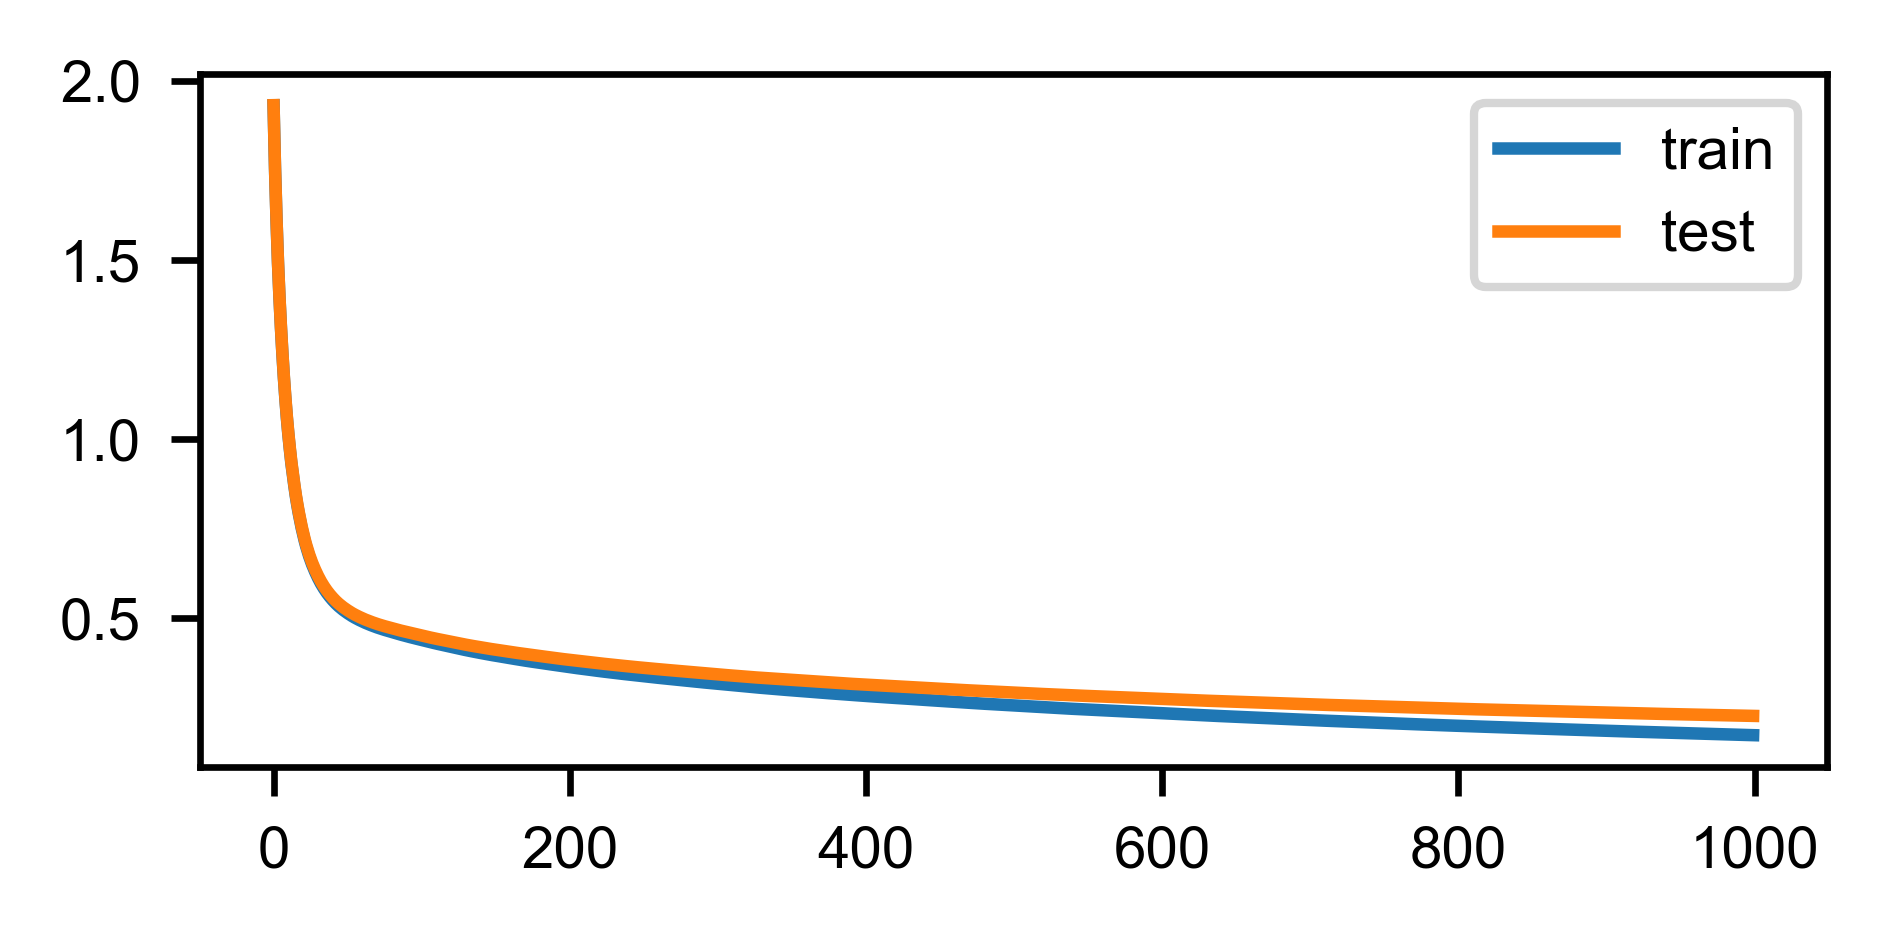

In [9]:
plt.figure(figsize=[3.5, 1.5])
plt.plot(np.arange(1000), cvresult_values[:,0], label='train')
plt.plot(np.arange(1000), cvresult_values[:,2], label='test')
plt.legend()

In [10]:
'''
param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':range(1,6,2)
}
xgboost =xgb.XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'multi:softmax',num_class = 9, scale_pos_weight=1, seed=27)
gsearch1 = GridSearchCV(estimator=xgboost, param_grid=param_test1, n_jobs=6, cv=5, scoring='balanced_accuracy', verbose=3)
gsearch1.fit(train_data_feature, train_data_class)
joblib.dump(gsearch1, './result/classifier/GridSearchXgBoost_without_intensity.joblib')
'''
gsearch1 = joblib.load('./result/classifier/GridSearchXgBoost_without_intensity.joblib')

In [11]:
'''
param_test2 = {
    'max_depth':[9,11,13],
    'min_child_weight':range(1,8,2)
}
xgboost =xgb.XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=5,
                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'multi:softmax',num_class = 9, scale_pos_weight=1, seed=27)
gsearch2 = GridSearchCV(estimator=xgboost, param_grid=param_test2, n_jobs=6, cv=5, scoring='balanced_accuracy', verbose=3)
gsearch2.fit(train_data_feature, train_data_class)

with open("./result/classifier/GridSearchCV2_XGBoost_without_intensity.pkl","wb") as file:
    pickle.dump(gsearch2_cv_results_, file)
'''

with open("./result/classifier/GridSearchCV2_XGBoost_without_intensity.pkl","rb") as file:
    gsearch2_cv_results_ = pickle.load(file)

In [12]:
'''
param_test3 = {
    'max_depth':[15]
}
xgboost =xgb.XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=5,
                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'multi:softmax',num_class = 9, scale_pos_weight=1, seed=27)
gsearch3 = GridSearchCV(estimator=xgboost, param_grid=param_test3, n_jobs=4, cv=5, scoring='balanced_accuracy', verbose=3)
gsearch3.fit(train_data_feature, train_data_class)
joblib.dump(gsearch3, './result/classifier/GridSearchXgBoost_without_intensity3.joblib')
'''

gsearch3 = joblib.load('./result/classifier/GridSearchXgBoost_without_intensity3.joblib')

In [13]:
train_score = list(gsearch1.cv_results_['mean_train_score'][2:-1:3] ) + list(gsearch2_cv_results_['mean_train_score'][2::4]) + list(gsearch3.cv_results_['mean_train_score'])
test_score = list(gsearch1.cv_results_['mean_test_score'][2:-1:3] ) + list(gsearch2_cv_results_['mean_test_score'][2::4]) + list(gsearch3.cv_results_['mean_test_score'])

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


[Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '11'),
 Text(0, 0, '13'),
 Text(0, 0, '15')]

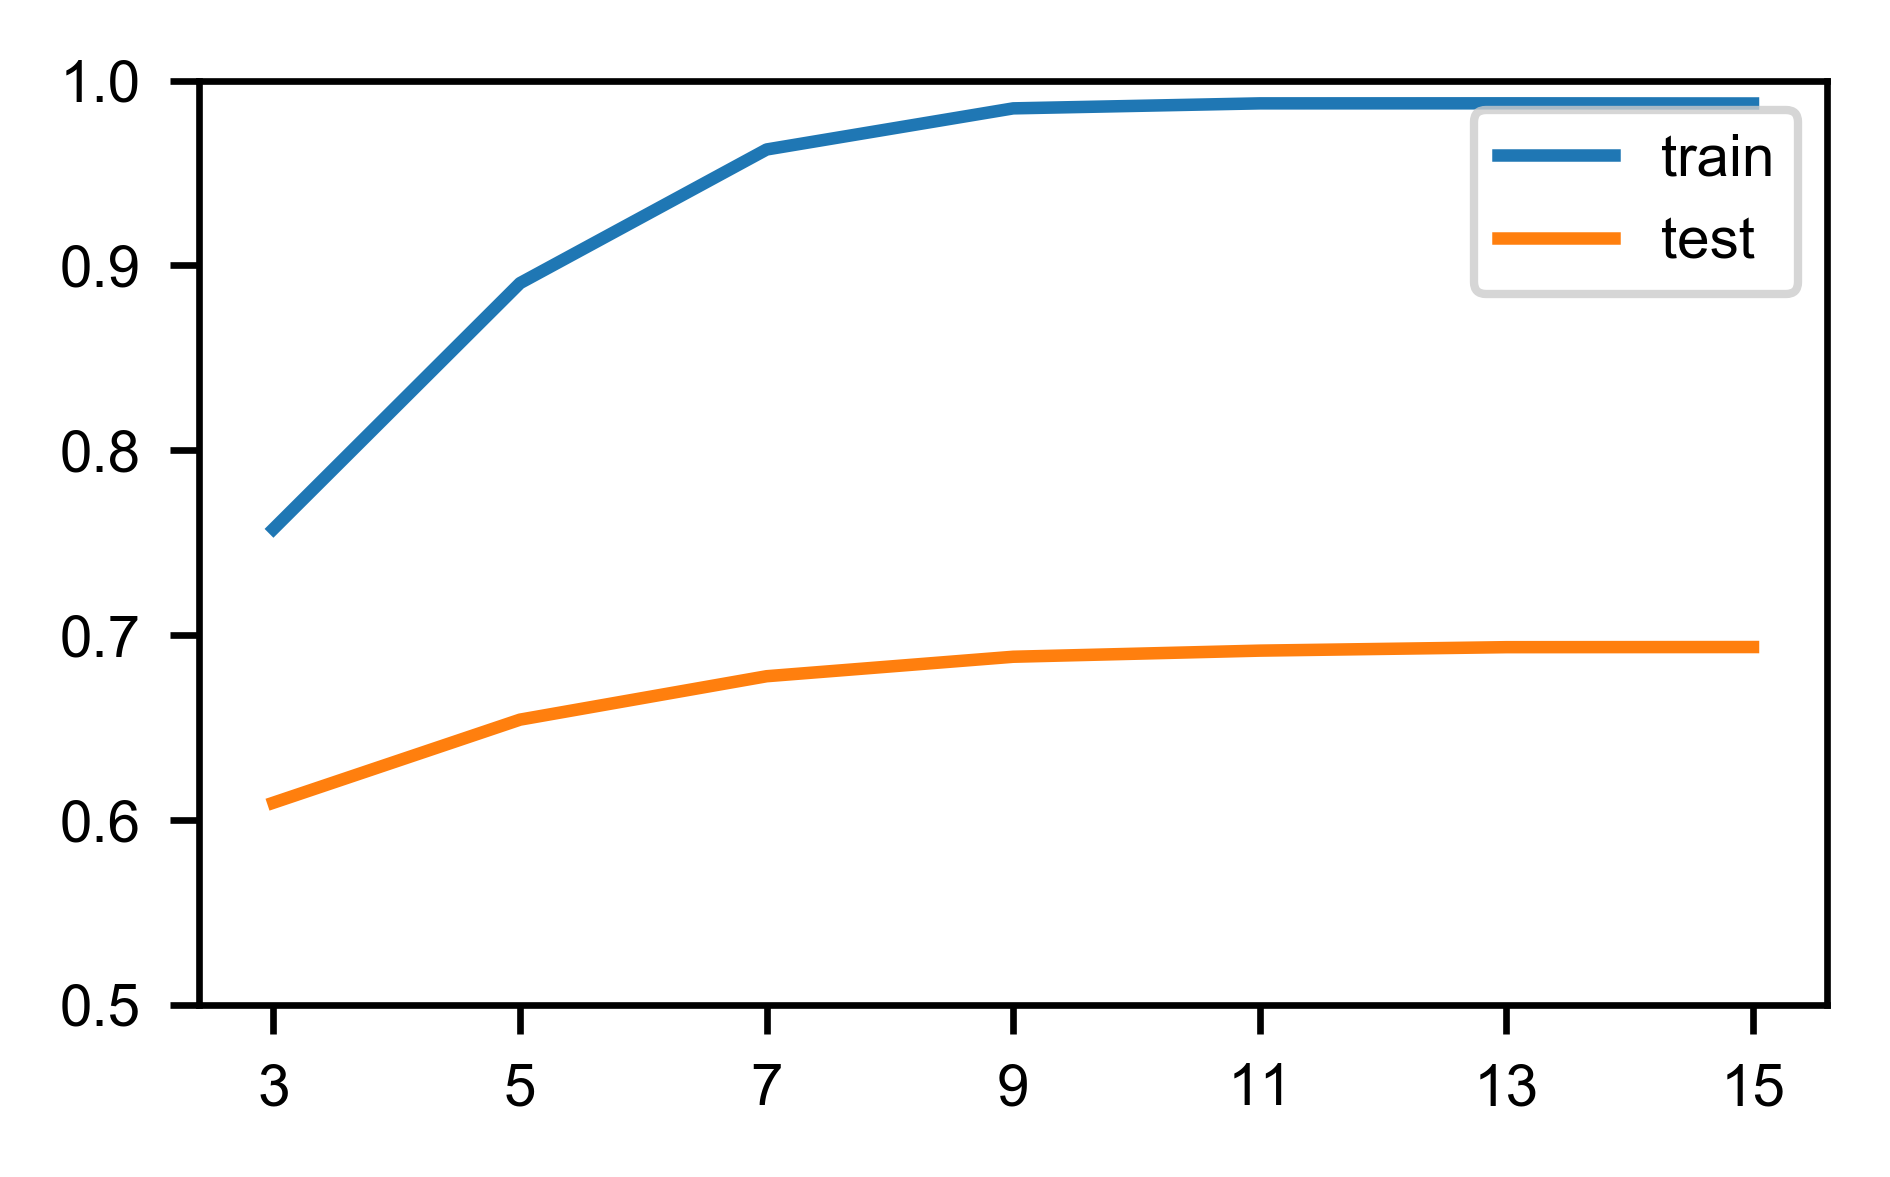

In [14]:
plt.figure(figsize=[3.5,2])
plt.plot(range(len(train_score)), train_score, label='train')
plt.plot(range(len(test_score)), test_score, label='test')
plt.legend()

ax = plt.gca()
ax.set_ylim(0.5,1)
ax.set_xticklabels(range(1,17,2))

#### XGBoost without intensity ($n\_estimators=500, max\_depth=11$)

In [15]:
'''
clf_XGBoost_without_i = xgb.XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 500,
    max_depth = 11,
    min_child_weight = 5,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree=0.8,
    objective = 'multi:softprob',
    num_class = 9,
    n_jobs = 6,
    seed = 27)
clf_XGBoost_without_i.fit(train_data_feature,train_data_class)
joblib.dump(clf_XGBoost_without_i, './result/classifier/XGBoost_without_intensity.joblib')
'''

clf_XGBoost_without_i = joblib.load('./result/classifier/XGBoost_without_intensity.joblib')

In [16]:
XGBoost_without_i = clf_XGBoost_without_i.predict(test_data_feature)
test_xyz = test_data[:, -3:] 
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
smooth_XGBoost_without_i = smooth_result(XGBoost_without_i, ind)

tmp = np.hstack([test_xyz, smooth_XGBoost_without_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_without_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_XGBoost_without_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_without_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [17]:
precision_recall_fscore_support(test_data_class, smooth_XGBoost_without_i, average='weighted')

(0.7651860734929999, 0.7526219147871622, 0.7528524545704302, None)

In [18]:
precision_recall_fscore_support(test_data_class, smooth_XGBoost_without_i)

(array([0.26262626, 0.68355752, 0.86014202, 0.87721442, 0.48396675,
        0.92488103, 0.46332225, 0.35949714, 0.69856088]),
 array([0.04333333, 0.76312696, 0.7648893 , 0.38727077, 0.10980868,
        0.84476561, 0.44681041, 0.45398501, 0.84592262]),
 array([0.07439199, 0.72115403, 0.809724  , 0.5373246 , 0.17900286,
        0.88300983, 0.45491655, 0.40125358, 0.76521173]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

#### GMM for intensity of impervious surface and low vegetation classified by XGBoost without intensity

In [19]:
from sklearn import mixture

In [20]:
# smooth the intensity of LiDAR
test_i = test_data[:, -7]
neigh_i = test_i[ind]
smooth_test_i = np.average(neigh_i, axis=1)

In [21]:
# Gaussian mixture model for the intensity of low vegetation and impervious surface.
XGBoost_lv_im_i = smooth_test_i[np.logical_or(XGBoost_without_i == 1, XGBoost_without_i == 2)]
XGBoost_lv_im_i = XGBoost_lv_im_i.reshape((-1, 1))
GMM = mixture.GaussianMixture(n_components=2, random_state=0)
GMM.fit(XGBoost_lv_im_i)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

#### joint the classification of XGBoost without intensity and GMM

In [22]:
# calculate the ratio of larger and smaller for XGBoost without intensity
proba_XGBoost = clf_XGBoost_without_i.predict_proba(test_data_feature)
proba_XGBoost_lv_im = proba_XGBoost[np.logical_or(XGBoost_without_i == 1, XGBoost_without_i == 2), 1:3]
ratio_proba_XGBoost_lv_im = np.zeros(proba_XGBoost_lv_im.shape[0])

proba_XGBoost_lv_larger_im = proba_XGBoost_lv_im[:, 0] > proba_XGBoost_lv_im[:, 1]
ratio_proba_XGBoost_lv_im[proba_XGBoost_lv_larger_im] = np.divide(proba_XGBoost_lv_im[proba_XGBoost_lv_larger_im, 0],
                                                        proba_XGBoost_lv_im[proba_XGBoost_lv_larger_im, 1])

proba_XGBoost_lv_smaller_im = np.logical_not(proba_XGBoost_lv_larger_im)
ratio_proba_XGBoost_lv_im[proba_XGBoost_lv_smaller_im] = np.divide(proba_XGBoost_lv_im[proba_XGBoost_lv_smaller_im, 1],
                                                         proba_XGBoost_lv_im[proba_XGBoost_lv_smaller_im,0])

In [23]:
# calculate the ratio of larger and smaller for GMM

proba_GMM_lv_im = GMM.predict_proba(XGBoost_lv_im_i)
ratio_proba_GMM_lv_im = np.zeros(proba_GMM_lv_im.shape[0])

proba_GMM_lv_larger_im = proba_GMM_lv_im[:, 1] > proba_GMM_lv_im[:, 0]
ratio_proba_GMM_lv_im[proba_GMM_lv_larger_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_larger_im, 1],
                                                    proba_GMM_lv_im[proba_GMM_lv_larger_im, 0])

proba_GMM_lv_smaller_im = np.logical_not(proba_GMM_lv_larger_im)
ratio_proba_GMM_lv_im[proba_GMM_lv_smaller_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_smaller_im, 0],
                                                     proba_GMM_lv_im[proba_GMM_lv_smaller_im, 1])

In [24]:
# the result for ground level points
XGBoost_lv_im = XGBoost_without_i[np.logical_or(XGBoost_without_i==1, XGBoost_without_i==2)]
GMM_lv_im = GMM.predict(XGBoost_lv_im_i)

# set the semantic label for GMM clusters 
GMM_lv_im[GMM_lv_im==0] = 2

In [25]:
# calculate the effect of joint coefficient on the performance of the joint classification
effect_a = {'f1_lv': [],
            'f1_im': [],
            'Acc': []}
tmp = list(1/np.arange(2, 21, 1))
tmp.reverse()
list_a = tmp + list(np.arange(1, 21, 1))
for a in list_a:
    judge = a * ratio_proba_XGBoost_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
    refine_lv_im = np.zeros(judge.shape)
    refine_lv_im[judge] = XGBoost_lv_im[judge]
    refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]
    
    joint_result = np.copy(XGBoost_without_i)
    joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im
    smooth_joint_result = smooth_result(joint_result, ind)
    effect_a['Acc'].append(precision_recall_fscore_support(test_data_class, joint_result, average='weighted')[2])
    
    tmp = precision_recall_fscore_support(test_data_class, smooth_joint_result)
    effect_a['f1_lv'].append(tmp[2][1])
    effect_a['f1_im'].append(tmp[2][2])

with open("./result/classifier/XGBoost_effect_a.pkl","wb") as f:
    pickle.dump(effect_a,f)
    
with open("./result/classifier/XGBoost_effect_a.pkl","rb") as f:
    effect_a = pickle.load(f)    

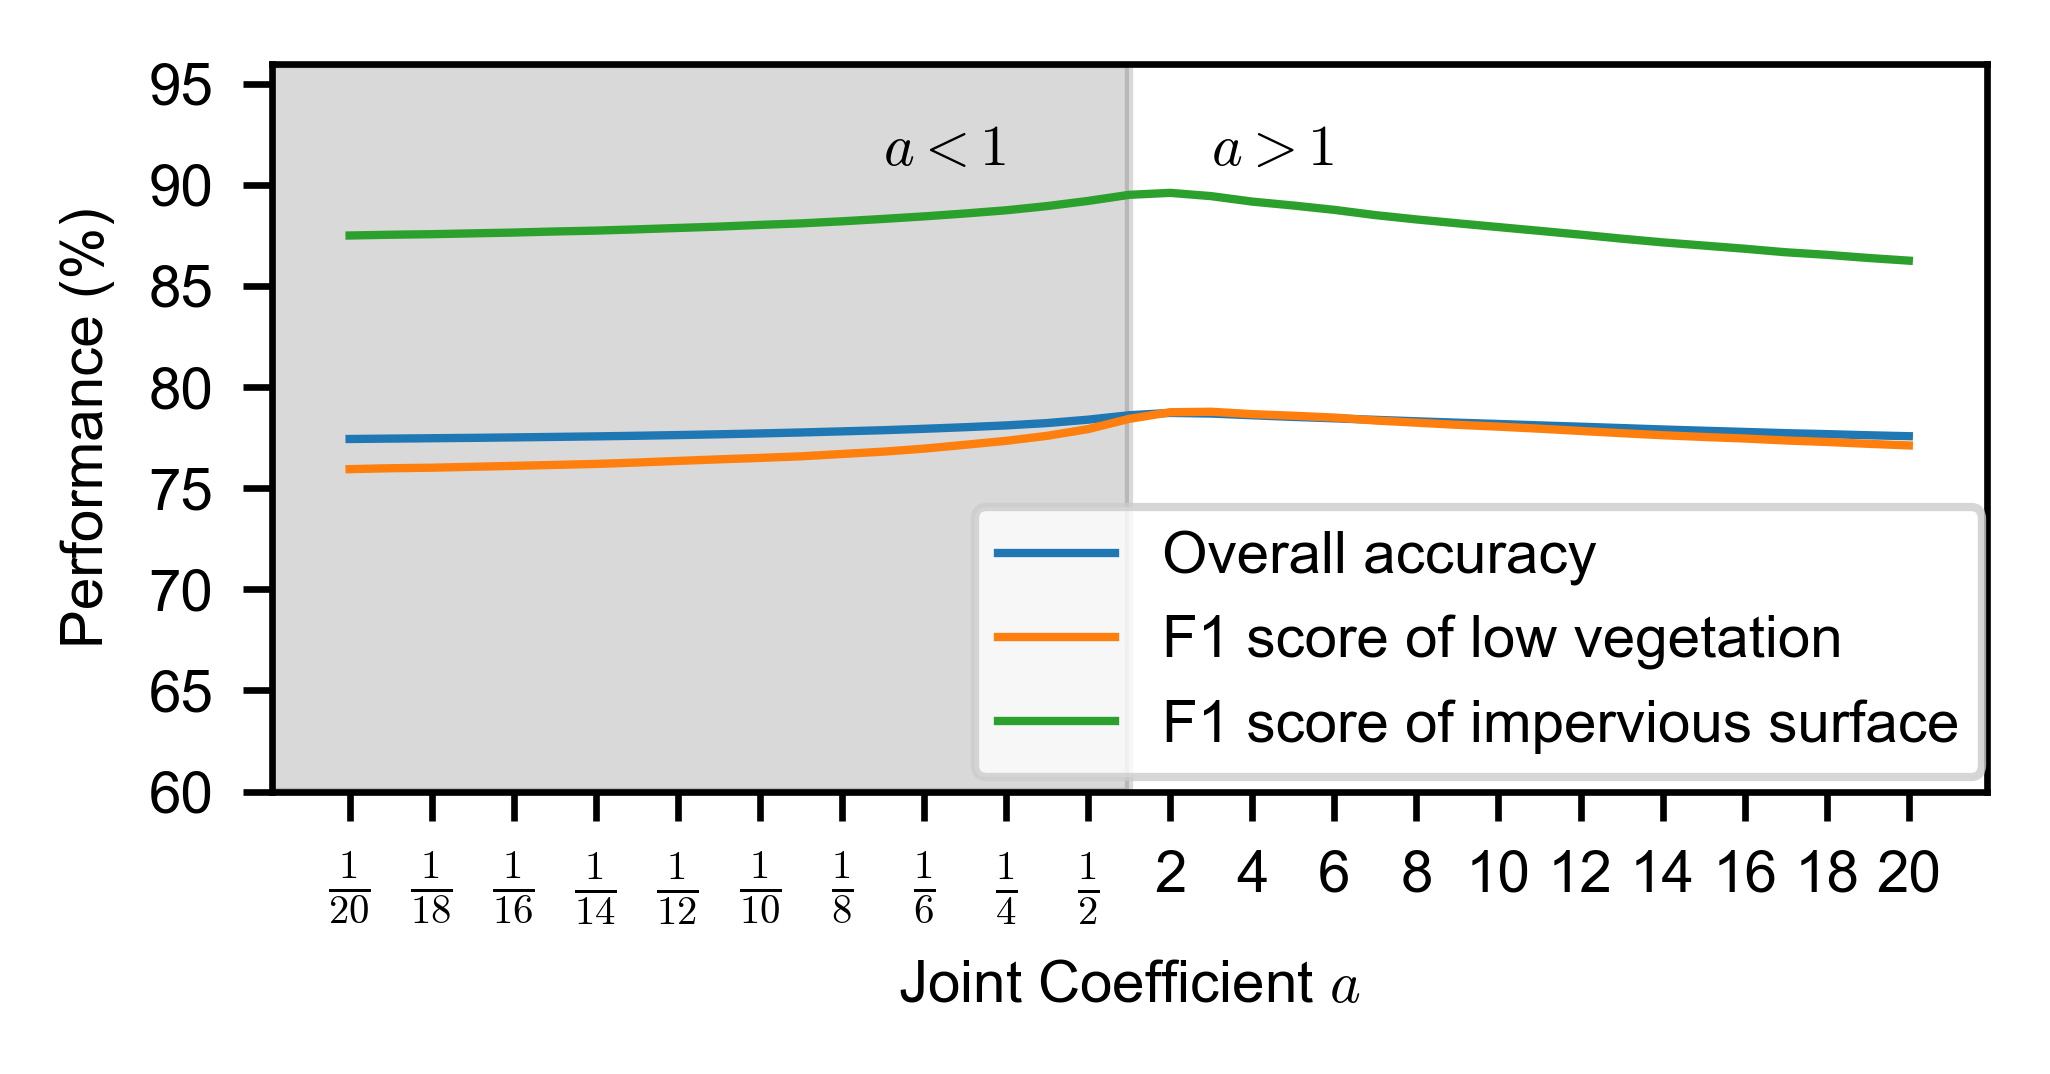

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 1.8))
x = x_ticks = np.arange(1, 40, 1)
ax.plot(x, effect_a['Acc'], label='Overall accuracy', lw=1)
ax.plot(x, effect_a['f1_lv'], label='F1 score of low vegetation', lw=1)
ax.plot(x, effect_a['f1_im'], label='F1 score of impervious surface', lw=1)
x_ticks = np.arange(1, 40, 2)
ax.set_xticks(x_ticks)

x_label = []
for i in range(2, 21, 2):
    x_label.append(r"$\frac{{{}}}{{{}}}$".format(1, i))
x_label.reverse()
for i in range(2, 21, 2):
    x_label.append(i)
ax.set_xticklabels(x_label)
ax.set_xlabel('Joint Coefficient $a$')


ax.set_ylim([0.6, 0.96])
ax.set_yticks(np.arange(0.6, 0.96, 0.05))
ax.set_yticklabels((np.arange(0.6, 0.96, 0.05)*100).astype('int'))
ax.set_ylabel('Performance (%)')

ax.legend(loc=[0.41, 0.02], ncol=1)
ax.add_patch(Rectangle((-1, 0.6), 21, 0.36, color='black', alpha=0.15))
ax.text(14, 0.91, '$a<1$')
ax.text(22, 0.91, '$a>1$')

plt.tight_layout()
plt.savefig("./result/figure/XGBoost_effect_a.png")

In [27]:
a = 2                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_XGBoost_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im = np.zeros(judge.shape)
refine_lv_im[judge] = XGBoost_lv_im[judge]
refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]

joint_result = np.copy(XGBoost_without_i)
joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im

In [28]:
smooth_joint_result = smooth_result(joint_result, ind)
tmp = np.hstack([test_xyz, smooth_joint_result.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_joint_result.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_joint_result == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_joint_result_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [29]:
# overall accuracy of joint method
precision_recall_fscore_support(test_data_class, smooth_joint_result, average='weighted')

(0.7990256025626379, 0.7909147434433914, 0.790106285153843, None)

In [30]:
# F1 score for all geo-object
precision_recall_fscore_support(test_data_class, smooth_joint_result)

(array([0.26262626, 0.78210342, 0.90165106, 0.87408313, 0.48513674,
        0.92483385, 0.46339212, 0.35901765, 0.69842865]),
 array([0.04333333, 0.79307934, 0.89048497, 0.38565264, 0.10994341,
        0.84475644, 0.44716679, 0.45414618, 0.84590418]),
 array([0.07439199, 0.78755314, 0.89603323, 0.53517964, 0.17926186,
        0.88298331, 0.45513489, 0.40101758, 0.76512485]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

### XGBoost with intensity

In [31]:
# smooth intensity
train_xyz = train_data[:, -3:]
intensity = train_data[:, -7]
kdt = KDTree(train_xyz, metric = 'euclidean')
ind = kdt.query(train_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

# concatenate intensity with other feature
train_data_feature_i = np.hstack((train_data_feature, smooth_intensity))

In [32]:
# same operation with training data
test_xyz = test_data[:, -3:]
intensity = test_data[:, -7]
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

test_data_feature_i = np.hstack((test_data_feature, smooth_intensity))

In [33]:
'''
clf_XGBoost_i = xgb.XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 500,
    max_depth = 11,
    min_child_weight = 5,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree=0.8,
    objective = 'multi:softprob',
    num_class = 9,
    n_jobs = 6,
    seed = 27)
clf_XGBoost_i.fit(train_data_feature_i,train_data_class)
joblib.dump(clf_XGBoost_i, './result/classifier/XGBoost_with_intensity.joblib')
'''

clf_XGBoost_i = joblib.load('./result/classifier/XGBoost_with_intensity.joblib')

In [34]:
XGBoost_with_i = clf_XGBoost_i.predict(test_data_feature_i)
smooth_XGBoost_with_i = smooth_result(XGBoost_with_i, ind)
tmp = np.hstack([test_xyz, smooth_XGBoost_with_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_with_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_XGBoost_with_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/XGBoost_with_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [35]:
precision_recall_fscore_support(test_data_class, smooth_XGBoost_with_i, average='weighted')

(0.8023968641562711, 0.7930156756257863, 0.7929094250750012, None)

In [36]:
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_XGBoost_with_i)

(array([0.3506, 0.7815, 0.9046, 0.8663, 0.492 , 0.9345, 0.4738, 0.353 ,
        0.6993]),
 array([0.09  , 0.8046, 0.8837, 0.4315, 0.1164, 0.8472, 0.4422, 0.452 ,
        0.8463]),
 array([0.1432, 0.7929, 0.894 , 0.5761, 0.1883, 0.8887, 0.4574, 0.3964,
        0.7658]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

### The confusion matrix between XGBoost considering intensity and the proposed method

In [37]:
# the consistence between joint and XGBoost_i result
precision_recall_fscore_support(smooth_XGBoost_with_i, smooth_joint_result, average='weighted')[1]

0.942451459965705

E:\als_fpfh_brf\Utils.py:70: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(confusion_matrix), **kwargs)
E:\als_fpfh_brf\Utils.py:136: RuntimeWarning: divide by zero encountered in log
  threshold = im.norm(np.log(data).max())/2.
E:\als_fpfh_brf\Utils.py:153: RuntimeWarning: divide by zero encountered in log
  kw.update(color=textcolors[im.norm(np.log(data[i, j])) > threshold])


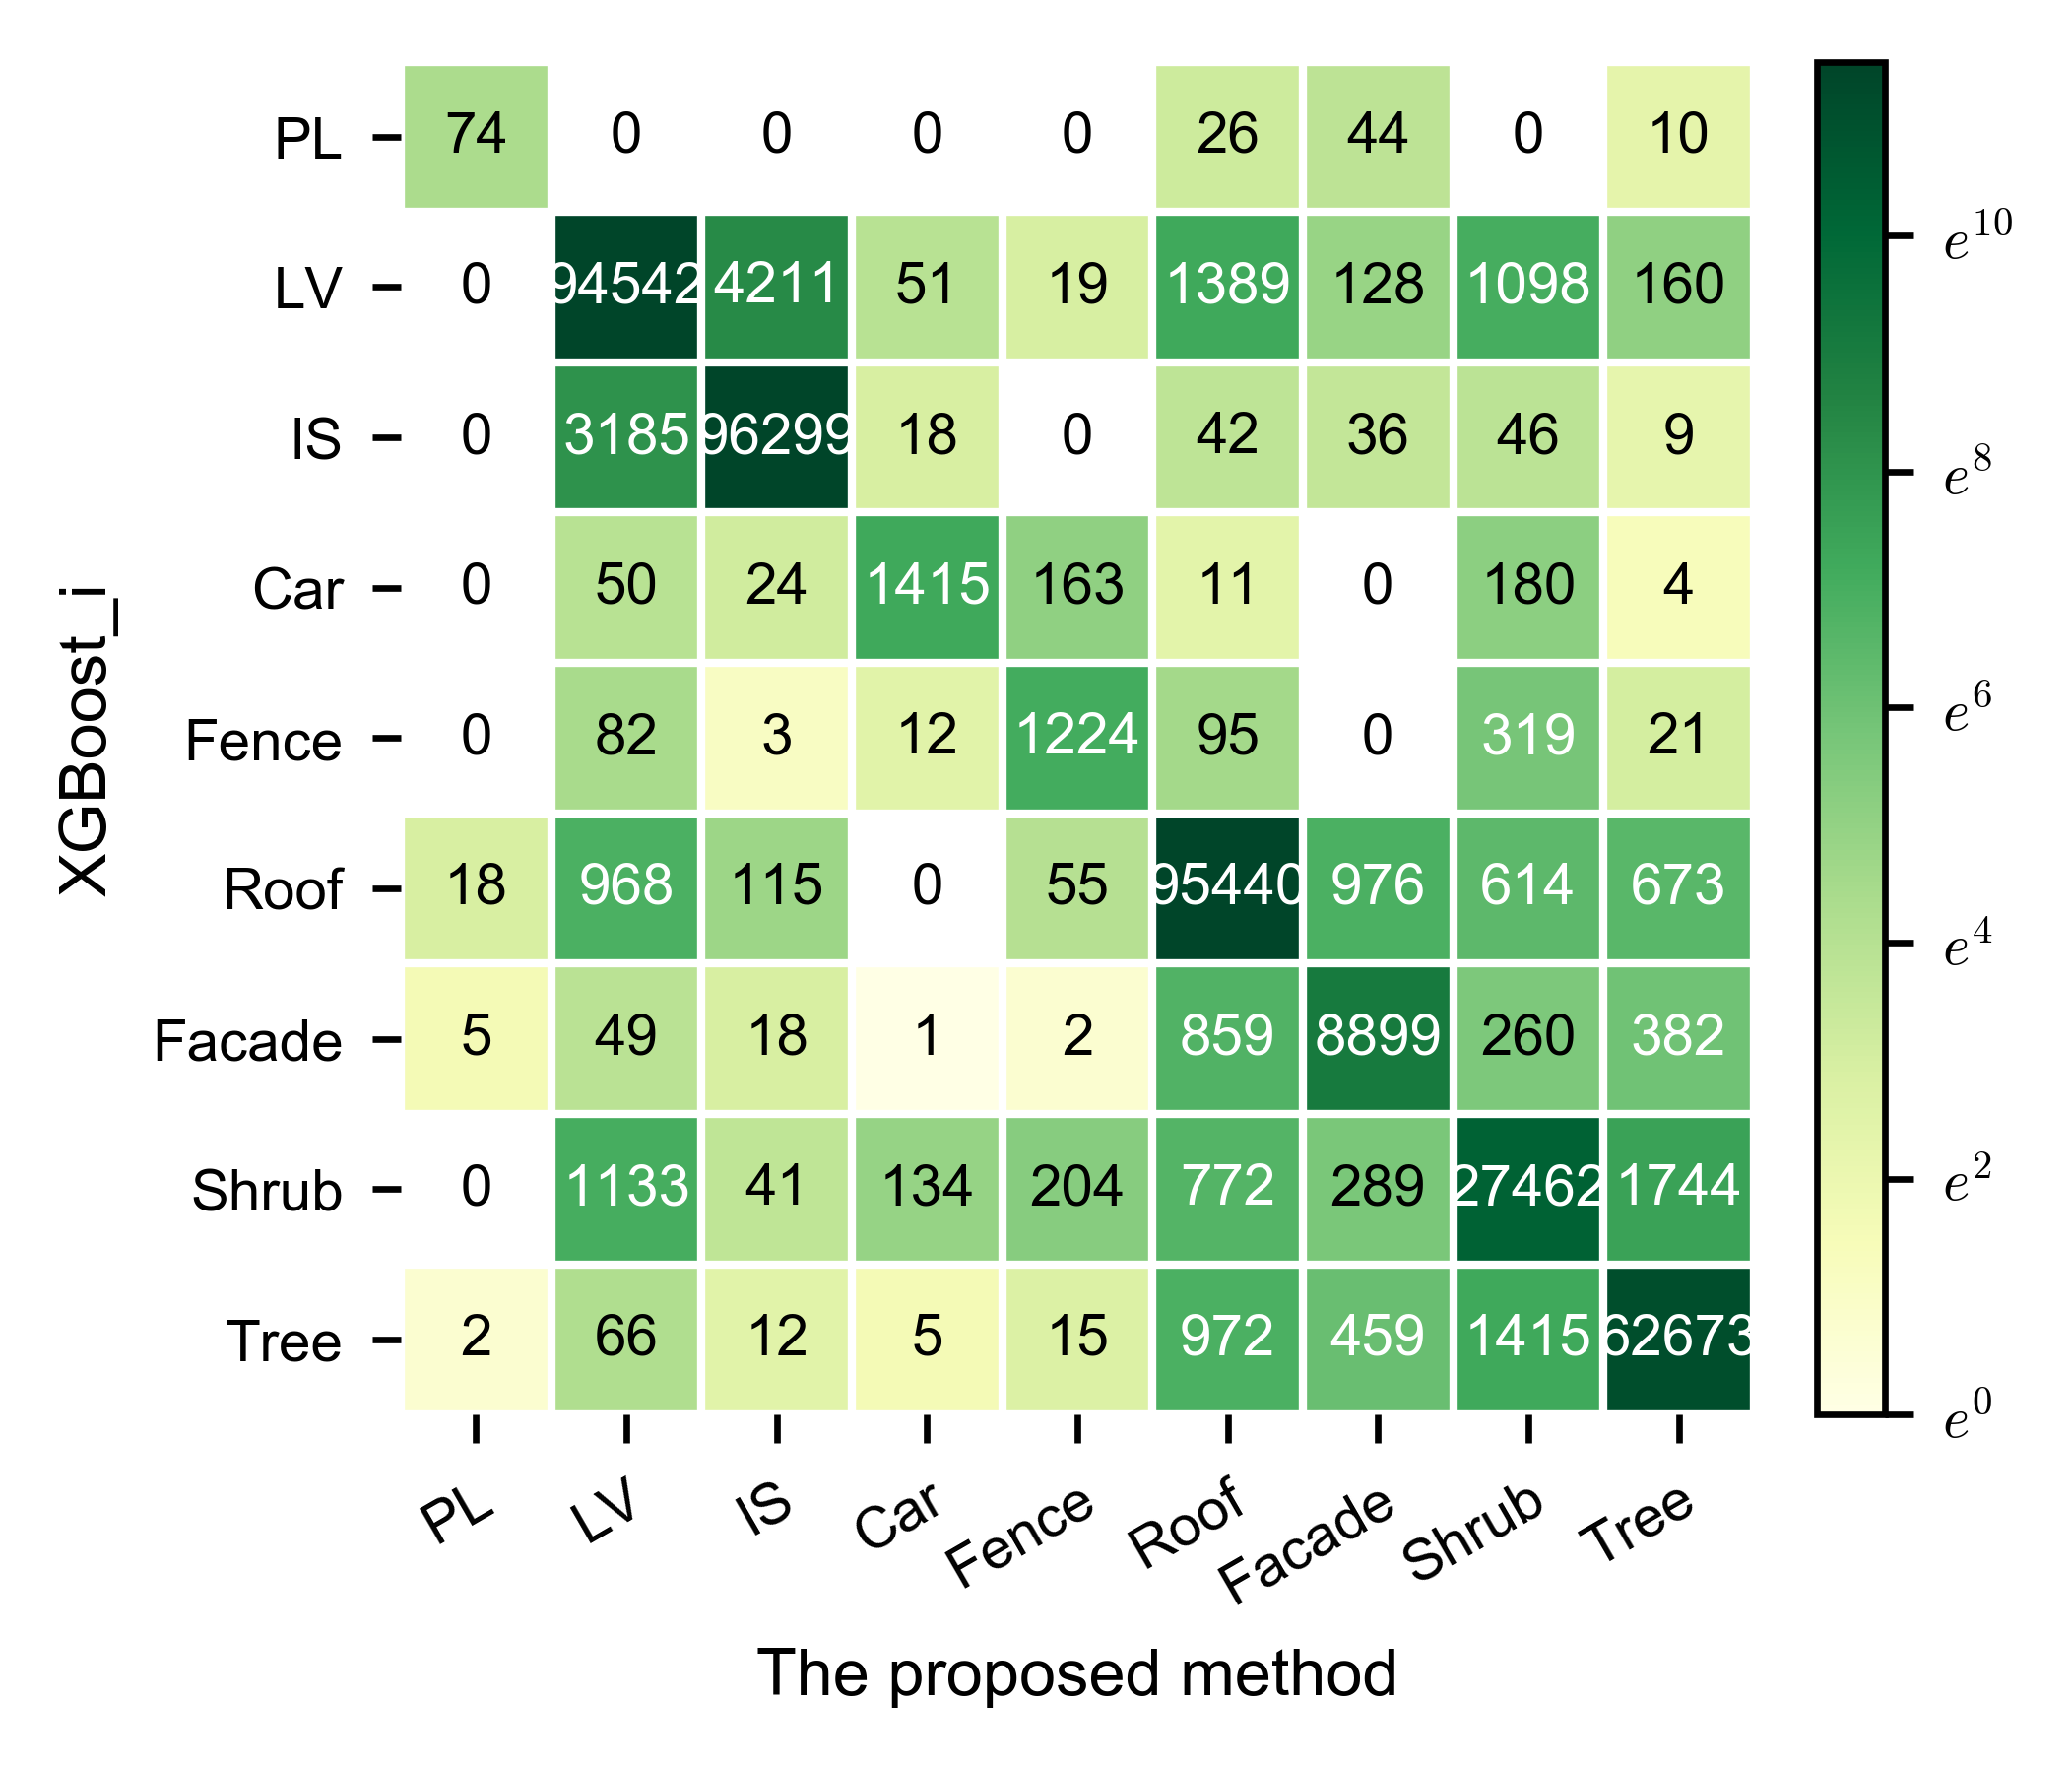

In [38]:
cnf_matrix = confusion_matrix(smooth_XGBoost_with_i, smooth_joint_result)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(3.5, 3))
im, cbar = plot_confusion_matrix(cnf_matrix, class_name=class_name, ax=ax,
                   cmap="YlGn")
texts = annotate_confusion(im, valfmt="{x:d}", data=cnf_matrix, fontsize=7)
plt.ylabel('XGBoost_i', fontsize=8)
plt.xlabel('The proposed method', fontsize=8)
plt.tight_layout()
plt.savefig("./result/figure/confusion_matrix_XGBoost_i_proposed.png")

#### simulate the intensity using range function

In [39]:
h = test_data_feature[:, -1]
modify = ((500-h) / (700-h))**2
intensity = test_data[:, -7]
modified_intensity = modify * intensity

In [40]:
# smooth modified intensity using mean within k-neighbourhood
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_modified_intensity = modified_intensity[ind]
smooth_modified_intensity = np.average(neigh_modified_intensity, axis=1)
smooth_modified_intensity = smooth_modified_intensity.reshape((-1, 1))
test_data_feature_mi = np.hstack((test_data_feature, smooth_modified_intensity))

#### XGBoost with intensity to handle intensity after modifying

In [41]:
XGBoost_with_mi = clf_XGBoost_i.predict(test_data_feature_mi)
smooth_XGBoost_with_mi = smooth_result(XGBoost_with_mi, ind)

In [42]:
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_XGBoost_with_mi)

(array([0.2915, 0.8143, 0.8072, 0.8164, 0.6801, 0.8832, 0.5077, 0.3685,
        0.6973]),
 array([0.12  , 0.6347, 0.9507, 0.4868, 0.0544, 0.8674, 0.4363, 0.4232,
        0.8537]),
 array([0.17  , 0.7134, 0.8731, 0.6099, 0.1008, 0.8752, 0.4693, 0.3939,
        0.7676]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [43]:
precision_recall_fscore_support(test_data_class, smooth_XGBoost_with_mi, average='weighted')

(0.7769824107832634, 0.7727374296248439, 0.7642657737205919, None)

#### Joint method for handling intensity after modifying

In [44]:
XGBoost_lv_im_mi = smooth_modified_intensity[np.logical_or(XGBoost_without_i == 1, XGBoost_without_i == 2)]
XGBoost_lv_im_mi = XGBoost_lv_im_mi.reshape((-1, 1))
GMM_mi = mixture.GaussianMixture(n_components=2, random_state=0)
GMM_mi.fit(XGBoost_lv_im_mi)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [45]:
proba_GMM_lv_im_mi = GMM_mi.predict_proba(XGBoost_lv_im_mi)

# calculate the ratio of larger and smaller
ratio_proba_GMM_lv_im_mi = np.zeros(proba_GMM_lv_im_mi.shape[0])

proba_GMM_lv_larger_im_mi = proba_GMM_lv_im_mi[:, 1] > proba_GMM_lv_im_mi[:, 0]
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 1],
                                                                proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 0])

proba_GMM_lv_smaller_im_mi = np.logical_not(proba_GMM_lv_larger_im_mi)
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 0],
                                                                 proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 1])

In [46]:
XGBoost_lv_im = XGBoost_without_i[np.logical_or(XGBoost_without_i==1, XGBoost_without_i==2)]

# associate cluster with semantic label using knowledge
GMM_lv_im_mi = GMM_mi.predict(XGBoost_lv_im_mi)
GMM_lv_im_mi[GMM_lv_im_mi==0] = 2

In [47]:
a = 2                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_XGBoost_lv_im >= ratio_proba_GMM_lv_im_mi   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im_mi = np.zeros(judge.shape)
refine_lv_im_mi[judge] = XGBoost_lv_im[judge]
refine_lv_im_mi[np.logical_not(judge)] = GMM_lv_im_mi[np.logical_not(judge)]

joint_result_mi = np.copy(XGBoost_without_i)
joint_result_mi[np.logical_or(joint_result_mi==1, joint_result_mi==2)] = refine_lv_im_mi
smooth_joint_result_mi = smooth_result(joint_result_mi, ind)

In [48]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi, average='weighted')

(0.7990395419408453, 0.7909293163833849, 0.7901205944032811, None)

In [49]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi)

(array([0.2626, 0.7821, 0.9017, 0.8741, 0.4851, 0.9248, 0.4634, 0.359 ,
        0.6984]),
 array([0.0433, 0.7931, 0.8905, 0.3857, 0.1099, 0.8448, 0.4472, 0.4541,
        0.8459]),
 array([0.0744, 0.7876, 0.8961, 0.5352, 0.1793, 0.883 , 0.4551, 0.401 ,
        0.7651]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))